# Importar librerias

In [29]:
import chardet
import pandas as pd
import nltk
import re
import numpy as np
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from fuzzywuzzy import process, fuzz

c:\Users\esteb\AppData\Local\Programs\Python\Python38\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# Lectura de los datos

In [2]:
# Abre el archivo en modo binario para detectar su encoding
with open('../data/Online_Retail.csv', 'rb') as file:
    raw_data = file.read()
    result = chardet.detect(raw_data)
    encoding = result['encoding']
    print(f"El encoding detectado es: {encoding}")

El encoding detectado es: ISO-8859-1


In [4]:
# Lectura del dataset 
df_online_retail = pd.read_csv('../data/Online_Retail.csv', encoding=encoding)
df_online_retail.head()

,INVOICE_NO,STOCK_CODE,DESCRIPTION,QUANTITY,INVOICE_DATE,UNIT_PRICE,CUSTOMER_ID,REGION
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2019 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/2019 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2019 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2019 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2019 08:26,3.39,17850.0,United Kingdom


In [5]:
# Descripción detallada
df_online_retail.describe(include='all')

,INVOICE_NO,STOCK_CODE,DESCRIPTION,QUANTITY,INVOICE_DATE,UNIT_PRICE,CUSTOMER_ID,REGION
count,541909,541909,540455,541909.000000,541909,541909.000000,406829.000000,541909
unique,25900,4070,4214,NaN,23260,NaN,NaN,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,31/10/2020 14:41,NaN,NaN,United Kingdom
freq,1114,2313,2369,NaN,1114,NaN,NaN,495478
mean,NaN,NaN,NaN,9.552250,NaN,4.611114,15287.690570,NaN
std,NaN,NaN,NaN,218.081158,NaN,96.759853,1713.600303,NaN
min,NaN,NaN,NaN,-80995.000000,NaN,-11062.060000,12346.000000,NaN
25%,NaN,NaN,NaN,1.000000,NaN,1.250000,13953.000000,NaN
50%,NaN,NaN,NaN,3.000000,NaN,2.080000,15152.000000,NaN
75%,NaN,NaN,NaN,10.000000,NaN,4.130000,16791.000000,NaN


In [6]:
# Verificar tipos de datos, numero de observaciones, existencia de valores ausentes
df_online_retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   INVOICE_NO    541909 non-null  object 
 1   STOCK_CODE    541909 non-null  object 
 2   DESCRIPTION   540455 non-null  object 
 3   QUANTITY      541909 non-null  int64  
 4   INVOICE_DATE  541909 non-null  object 
 5   UNIT_PRICE    541909 non-null  float64
 6   CUSTOMER_ID   406829 non-null  float64
 7   REGION        541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Notas:
- Tenemos 541mil datos. Una cantidad muy grande. 
- Cambiar nombre de columnas a miniusculas
- Columnas con valores ausentes: description, customer_id
    - Encontrar el id a partir de la descripcion? o el stock_code, lo mismo para description
- invoice_no, customer_id a int?
- invoice_date a time
- Por que tenemos números negativos en quantity y unit_price?
- Verificar que no existan valores fantasma en la descripcion y la region
    - Pasar a minusculas y verificar 

# Limpieza de los datos

## Formato al nombre de las columnas

In [11]:
# Pasar el nombre de las columnas a mínusculas y dejarlo en snake_case
df_online_retail.columns = df_online_retail.columns.str.lower()
df_online_retail.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'region'],
      dtype='object')

## Eliminar valores ausentes

In [12]:
# Calcular el porcentaje de valores ausentes por columna
df_online_retail.isna().sum()/len(df_online_retail)*100

invoice_no       0.000000
stock_code       0.000000
description      0.268311
quantity         0.000000
invoice_date     0.000000
unit_price       0.000000
customer_id     24.926694
region           0.000000
dtype: float64

Se optara por dos soluciones para las columnas de valores ausentes:
- desciption: Al solo contar con 0.2% de los datos como valores ausentes se eliminaran. Tenemos suficientes datos para hacer un analisis completo (500mil datos).
- customer_id: Hay un alto porcentaje de valores ausentes, 24% es inusual. Al no contar con una fuente para completar los datos y ser el porcentaje de valores ausentes muy alto, se decidio por remplazarlos por la palabra 'unknown'.

In [13]:
# Tratamiento de valores ausentes
df_online_retail_cleaned = df_online_retail.copy()
df_online_retail_cleaned = df_online_retail_cleaned.dropna(subset=['description'])   # Para la columna descripcion se elimininaran al ser solo el 0.2% de los datos. 
df_online_retail_cleaned = df_online_retail_cleaned.fillna('unknown')                # Para la columna customer_id se reemplazaran por la palabra unknown

In [14]:
# Verificar que no existan valores ausentes
df_online_retail_cleaned.isna().sum()/len(df_online_retail)*100

invoice_no      0.0
stock_code      0.0
description     0.0
quantity        0.0
invoice_date    0.0
unit_price      0.0
customer_id     0.0
region          0.0
dtype: float64

## Eliminar cadenas vacías

In [44]:
# Eliminar caracteres especiales usando una expresión regular
df_online_retail_cleaned['description'] = df_online_retail_cleaned['description'].str.replace(r'[^A-Za-z0-9\s]', '', regex=True)

# Limpiar la columna 'description' eliminando espacios en blanco y convirtiendo None a cadenas vacías
df_online_retail_cleaned['description'] = df_online_retail_cleaned['description'].str.strip()

# Encontrar cadenas vacías
empty_strings = df_online_retail_cleaned[df_online_retail_cleaned['description'] == '']
empty_strings.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region
7313,537032,21275,,-30,2019-03-12 16:50:00,0.0,unknown,United Kingdom
21518,538090,20956,,-723,2019-09-12 14:48:00,0.0,unknown,United Kingdom
38261,539494,21479,,752,2019-12-20 10:36:00,0.0,unknown,United Kingdom
43662,540100,22837,,-106,2020-04-01 16:53:00,0.0,unknown,United Kingdom
50806,540558,21258,,-29,2020-10-01 10:04:00,0.0,unknown,United Kingdom


In [47]:
# Remplazar cadenas vacias por unknown
df_online_retail_cleaned = df_online_retail_cleaned.replace('','unknown')

# Encontrar cadenas vacías
empty_strings = df_online_retail_cleaned[df_online_retail_cleaned['description'] == '']
empty_strings.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region


## Cambiar los tipos de datos

In [17]:
# Pasar la columna invoice_date a tipo datetime
df_online_retail_cleaned['invoice_date'] = pd.to_datetime(df_online_retail_cleaned['invoice_date'])

# Verificar el cambio
df_online_retail_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 540455 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice_no    540455 non-null  object        
 1   stock_code    540455 non-null  object        
 2   description   540455 non-null  object        
 3   quantity      540455 non-null  int64         
 4   invoice_date  540455 non-null  datetime64[ns]
 5   unit_price    540455 non-null  float64       
 6   customer_id   540455 non-null  object        
 7   region        540455 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 37.1+ MB


## Duplicados

## Explicitos

In [20]:
# Cantidad de duplicados
df_online_retail_cleaned.duplicated().sum()

5268

In [21]:
# Ver las observaciones duplicadas
df_online_retail_cleaned[df_online_retail_cleaned.duplicated()]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2019-01-12 11:45:00,1.25,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2019-01-12 11:45:00,2.10,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2019-01-12 11:45:00,2.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2019-01-12 11:45:00,4.95,17908.0,United Kingdom
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,2019-01-12 11:49:00,2.95,17920.0,United Kingdom
...,...,...,...,...,...,...,...,...
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,2020-09-12 11:34:00,0.39,14446.0,United Kingdom
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,2020-09-12 11:34:00,2.49,14446.0,United Kingdom
541692,581538,22992,REVOLVER WOODEN RULER,1,2020-09-12 11:34:00,1.95,14446.0,United Kingdom
541699,581538,22694,WICKER STAR,1,2020-09-12 11:34:00,2.10,14446.0,United Kingdom


In [24]:
# Tomar una de ellas y compararla con la original
df_online_retail_cleaned[(df_online_retail_cleaned.invoice_no == '536409') & (df_online_retail_cleaned.stock_code == '21866')]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2019-01-12 11:45:00,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2019-01-12 11:45:00,1.25,17908.0,United Kingdom


Nota:
- Si fuese una factura diferentes invoice_no cambiaria...
- Si fuesen dos productos en una factura la cantidad aumentaria...
Por estas dos raones, se eliminaran al considerarse duplicados. 

In [27]:
# Eliminar duplicados explicitos
df_online_retail_cleaned.drop_duplicates(inplace=True)

# Verificar el cambio
df_online_retail_cleaned.duplicated().sum()

0

## Implicitos

### Description

In [30]:
# Función para encontrar posibles errores de tipeo
def find_typo_matches(descriptions, threshold=80):
    unique_descriptions = list(set(descriptions))
    typo_matches = {}
    for desc in unique_descriptions:
        matches = process.extract(desc, unique_descriptions, scorer=fuzz.ratio)
        for match in matches:
            if match[0] != desc and match[1] >= threshold:
                if desc not in typo_matches:
                    typo_matches[desc] = []
                typo_matches[desc].append(match)
    return typo_matches

In [42]:
# Encontrar errores de tipeo en la columna 'description'
typo_matches = find_typo_matches(df_online_retail_cleaned['description'])

KeyboardInterrupt: 

### Region

# -------------HASTA AQUI TODO CORRECTO LO DEMAS ES ESPECULACIÓN----------------

# Explorar Region

In [51]:
trans_by_region = df_online_retail.region.value_counts().sort_values(ascending=False)
trans_by_region

United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon 

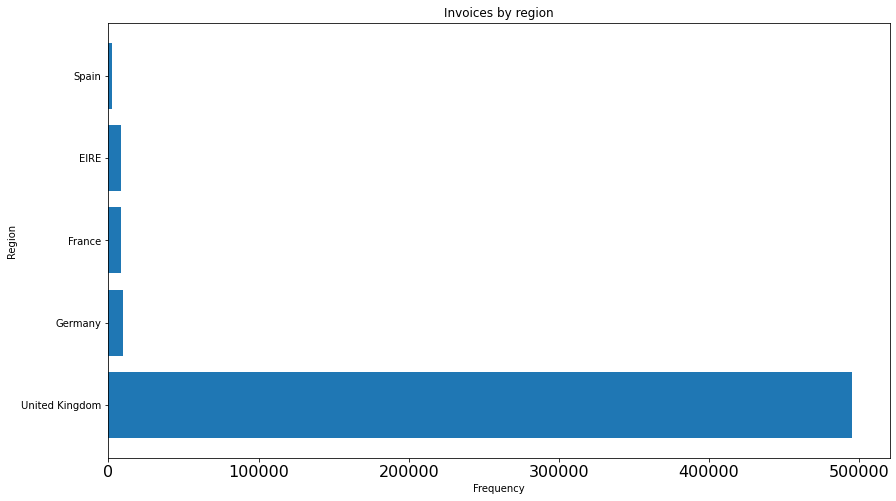

In [70]:
plt.figure(figsize=(14, 8))
plt.barh(trans_by_region.head().index, trans_by_region.head().values)
plt.title('Invoices by region')
plt.ylabel('Region')
plt.xlabel('Frequency')
#plt.xscale('log')
plt.xticks(fontsize=16)
plt.show()

## Como se ven las observaciones con region sin especificar?

In [55]:
df_online_retail[df_online_retail.region == 'Unspecified']

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region
152712,549687,20685,DOORMAT RED RETROSPOT,2,11/04/2020 13:29,7.95,12363.0,Unspecified
152713,549687,22691,DOORMAT WELCOME SUNRISE,2,11/04/2020 13:29,7.95,12363.0,Unspecified
152714,549687,48116,DOORMAT MULTICOLOUR STRIPE,2,11/04/2020 13:29,7.95,12363.0,Unspecified
152715,549687,21213,PACK OF 72 SKULL CAKE CASES,24,11/04/2020 13:29,0.55,12363.0,Unspecified
152716,549687,21977,PACK OF 60 PINK PAISLEY CAKE CASES,24,11/04/2020 13:29,0.55,12363.0,Unspecified
...,...,...,...,...,...,...,...,...
498778,578539,22560,TRADITIONAL MODELLING CLAY,24,24/11/2020 14:55,1.25,NaN,Unspecified
498779,578539,23570,TRADITIONAL PICK UP STICKS GAME,12,24/11/2020 14:55,1.25,NaN,Unspecified
498780,578539,23571,TRADITIONAL NAUGHTS & CROSSES,12,24/11/2020 14:55,1.65,NaN,Unspecified
498781,578539,84992,72 SWEETHEART FAIRY CAKE CASES,24,24/11/2020 14:55,0.55,NaN,Unspecified


In [56]:
df_online_retail[df_online_retail.customer_id == 12363.0]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region
152712,549687,20685,DOORMAT RED RETROSPOT,2,11/04/2020 13:29,7.95,12363.0,Unspecified
152713,549687,22691,DOORMAT WELCOME SUNRISE,2,11/04/2020 13:29,7.95,12363.0,Unspecified
152714,549687,48116,DOORMAT MULTICOLOUR STRIPE,2,11/04/2020 13:29,7.95,12363.0,Unspecified
152715,549687,21213,PACK OF 72 SKULL CAKE CASES,24,11/04/2020 13:29,0.55,12363.0,Unspecified
152716,549687,21977,PACK OF 60 PINK PAISLEY CAKE CASES,24,11/04/2020 13:29,0.55,12363.0,Unspecified
152717,549687,21976,PACK OF 60 MUSHROOM CAKE CASES,24,11/04/2020 13:29,0.55,12363.0,Unspecified
152718,549687,21212,PACK OF 72 RETROSPOT CAKE CASES,24,11/04/2020 13:29,0.55,12363.0,Unspecified
152719,549687,84992,72 SWEETHEART FAIRY CAKE CASES,24,11/04/2020 13:29,0.55,12363.0,Unspecified
152720,549687,84991,60 TEATIME FAIRY CAKE CASES,24,11/04/2020 13:29,0.55,12363.0,Unspecified
152721,549687,21974,SET OF 36 PAISLEY FLOWER DOILIES,12,11/04/2020 13:29,1.45,12363.0,Unspecified


In [59]:
df_online_retail[df_online_retail.invoice_date == '11/04/2020 13:29']

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region
152712,549687,20685,DOORMAT RED RETROSPOT,2,11/04/2020 13:29,7.95,12363.0,Unspecified
152713,549687,22691,DOORMAT WELCOME SUNRISE,2,11/04/2020 13:29,7.95,12363.0,Unspecified
152714,549687,48116,DOORMAT MULTICOLOUR STRIPE,2,11/04/2020 13:29,7.95,12363.0,Unspecified
152715,549687,21213,PACK OF 72 SKULL CAKE CASES,24,11/04/2020 13:29,0.55,12363.0,Unspecified
152716,549687,21977,PACK OF 60 PINK PAISLEY CAKE CASES,24,11/04/2020 13:29,0.55,12363.0,Unspecified
152717,549687,21976,PACK OF 60 MUSHROOM CAKE CASES,24,11/04/2020 13:29,0.55,12363.0,Unspecified
152718,549687,21212,PACK OF 72 RETROSPOT CAKE CASES,24,11/04/2020 13:29,0.55,12363.0,Unspecified
152719,549687,84992,72 SWEETHEART FAIRY CAKE CASES,24,11/04/2020 13:29,0.55,12363.0,Unspecified
152720,549687,84991,60 TEATIME FAIRY CAKE CASES,24,11/04/2020 13:29,0.55,12363.0,Unspecified
152721,549687,21974,SET OF 36 PAISLEY FLOWER DOILIES,12,11/04/2020 13:29,1.45,12363.0,Unspecified


In [62]:
df_online_retail[df_online_retail.invoice_no == '549687']

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region
152712,549687,20685,DOORMAT RED RETROSPOT,2,11/04/2020 13:29,7.95,12363.0,Unspecified
152713,549687,22691,DOORMAT WELCOME SUNRISE,2,11/04/2020 13:29,7.95,12363.0,Unspecified
152714,549687,48116,DOORMAT MULTICOLOUR STRIPE,2,11/04/2020 13:29,7.95,12363.0,Unspecified
152715,549687,21213,PACK OF 72 SKULL CAKE CASES,24,11/04/2020 13:29,0.55,12363.0,Unspecified
152716,549687,21977,PACK OF 60 PINK PAISLEY CAKE CASES,24,11/04/2020 13:29,0.55,12363.0,Unspecified
152717,549687,21976,PACK OF 60 MUSHROOM CAKE CASES,24,11/04/2020 13:29,0.55,12363.0,Unspecified
152718,549687,21212,PACK OF 72 RETROSPOT CAKE CASES,24,11/04/2020 13:29,0.55,12363.0,Unspecified
152719,549687,84992,72 SWEETHEART FAIRY CAKE CASES,24,11/04/2020 13:29,0.55,12363.0,Unspecified
152720,549687,84991,60 TEATIME FAIRY CAKE CASES,24,11/04/2020 13:29,0.55,12363.0,Unspecified
152721,549687,21974,SET OF 36 PAISLEY FLOWER DOILIES,12,11/04/2020 13:29,1.45,12363.0,Unspecified


- No hay paises que se repitan. 
- Usar ambas escalas, una lineal por default pero que puedan cambiar a escala logaritmica. 
- Limitar al top 5. 

# Explorar customer_id (valores ausentes)

In [66]:
df_customerid_nan = df_online_retail[df_online_retail.customer_id.isna()]
df_customerid_nan

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region
622,536414,22139,NaN,56,01/12/2019 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,01/12/2019 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,01/12/2019 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,01/12/2019 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,01/12/2019 14:32,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,09/12/2020 10:26,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,09/12/2020 10:26,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,09/12/2020 10:26,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,09/12/2020 10:26,10.79,NaN,United Kingdom


In [71]:
df_customerid_nan.region.value_counts()

United Kingdom    133600
EIRE                 711
Hong Kong            288
Unspecified          202
Switzerland          125
France                66
Israel                47
Portugal              39
Bahrain                2
Name: region, dtype: int64

In [74]:
# Pasar la columna a tipo datetime
df_customerid_nan['invoice_date'] = pd.to_datetime(df_customerid_nan['invoice_date'])

C:\Users\esteb\AppData\Local\Temp/ipykernel_13088/1514992174.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_customerid_nan['invoice_date'] = pd.to_datetime(df_customerid_nan['invoice_date'])


In [78]:
december_dates = df_customerid_nan[df_customerid_nan['invoice_date'].dt.day != 12]
december_dates

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region
26779,538524,10002,INFLATABLE POLITICAL GLOBE,2,2019-12-13 09:35:00,1.66,NaN,United Kingdom
26780,538524,10125,MINI FUNKY DESIGN TAPES,1,2019-12-13 09:35:00,1.66,NaN,United Kingdom
26781,538524,10135,COLOURING PENCILS BROWN TUBE,1,2019-12-13 09:35:00,2.51,NaN,United Kingdom
26782,538524,16235,RECYCLED PENCIL WITH RABBIT ERASER,6,2019-12-13 09:35:00,0.43,NaN,United Kingdom
26783,538524,17003,BROCADE RING PURSE,17,2019-12-13 09:35:00,0.43,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
515866,579787,21929,JUMBO BAG PINK VINTAGE PAISLEY,1,2020-11-30 15:33:00,4.13,NaN,United Kingdom
515867,579787,21930,JUMBO STORAGE BAG SKULLS,2,2020-11-30 15:33:00,4.13,NaN,United Kingdom
516171,579873,35819B,check,18,2020-11-30 17:00:00,0.00,NaN,United Kingdom
516188,579879,22759,check,17,2020-11-30 17:13:00,0.00,NaN,United Kingdom


Notas:
- Los valores ausentes no dependen de la region de la hora.

# Explorar description

In [74]:
df_online_retail.description.value_counts().index.str.lower()

Index(['white hanging heart t-light holder', 'regency cakestand 3 tier',
       'jumbo bag red retrospot', 'party bunting', 'lunch bag red retrospot',
       'assorted colour bird ornament', 'set of 3 cake tins pantry design ',
       'pack of 72 retrospot cake cases', 'lunch bag  black skull.',
       'natural slate heart chalkboard ',
       ...
       'lighthouse trading zero invc incorr', 'acrylic jewel snowflakepink',
       'tea time cake stand in gift box', 'white dove honeycomb paper garland',
       'keep out girls door hanger ', 'sold as set/6 by dotcom',
       'damages/dotcom?', 'on cargo order', 'opulent velvet set/3 candles',
       'show samples'],
      dtype='object', length=4214)

In [79]:
# Convertir NaN a 'Nothing'
df_online_retail.description.fillna('No description', inplace=True)

## Preprocesamiento de texto

In [80]:
# Descargar las stopwords en ingles para el preprocesamiento
nltk.download('stopwords')

# Función de preprocesamiento
def preprocesar_texto(texto):
    # Convertir a minúsculas
    texto = texto.lower()
    # Eliminar números y caracteres especiales
    texto = re.sub(r'\d+', '', texto)
    texto = re.sub(r'[^\w\s]', '', texto)
    # Eliminar espacios en blanco adicionales
    texto = texto.strip()
    # Eliminar stopwords
    stop_words = set(stopwords.words('english'))
    texto = ' '.join([word for word in texto.split() if word not in stop_words])
    return texto

# Aplicar preprocesamiento a las descripciones
df_online_retail['clean_description'] = df_online_retail['description'].apply(preprocesar_texto)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\esteb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Análisis de frecuencia de palabras

In [101]:
# Unir todas las descripciones en un solo texto
texto_total = ' '.join(df_online_retail['clean_description'])

# Contar la frecuencia de las palabras
frecuencia_palabras = Counter(texto_total.split())

# Mostrar las 10 palabras más comunes
print(frecuencia_palabras.most_common(10))

[('set', 63845), ('bag', 51911), ('red', 42902), ('heart', 39163), ('retrospot', 35126), ('vintage', 33748), ('design', 30066), ('pink', 29526), ('christmas', 25131), ('box', 24469)]


## Nube de palabras

In [116]:
# Generar la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate('hola hola')

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

ValueError: Only supported for TrueType fonts

## Explorar los datos de la columna invoice_no

In [32]:
# Ver con que letra comienzan el codigo
df_online_retail.invoice_no.value_counts().sort_index()

536365      7
536366      2
536367     12
536368      4
536369      1
           ..
C581484     1
C581490     2
C581499     1
C581568     1
C581569     2
Name: invoice_no, Length: 25900, dtype: int64

In [34]:
# Filtrar los datos que comiencen con la letra C
filtro = df_online_retail.invoice_no.str.startswith('C')
df_online_retail[filtro]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region
141,C536379,D,Discount,-1,01/12/2019 09:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,01/12/2019 09:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,01/12/2019 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,01/12/2019 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,01/12/2019 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,09/12/2020 09:57,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,09/12/2020 10:28,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,09/12/2020 11:57,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,09/12/2020 11:58,1.25,17315.0,United Kingdom


In [61]:
df_online_retail[df_online_retail.customer_id == 15311.0].sort_values('invoice_date').head(20)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region
78331,C542866,85063,CREAM SWEETHEART MAGAZINE RACK,-2,01/02/2020 12:14,14.95,15311.0,United Kingdom
78332,C542866,35004G,SET OF 3 GOLD FLYING DUCKS,-2,01/02/2020 12:14,1.95,15311.0,United Kingdom
78333,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,-2,01/02/2020 12:14,4.65,15311.0,United Kingdom
78530,542890,22087,PAPER BUNTING WHITE LACE,40,01/02/2020 13:25,2.55,15311.0,United Kingdom
78588,542890,22276,WASH BAG VINTAGE ROSE PAISLEY,2,01/02/2020 13:25,2.55,15311.0,United Kingdom
78587,542890,22278,OVERNIGHT BAG VINTAGE ROSE PAISLEY,2,01/02/2020 13:25,4.95,15311.0,United Kingdom
78586,542890,82583,HOT BATHS METAL SIGN,5,01/02/2020 13:25,2.10,15311.0,United Kingdom
78585,542890,82567,AIRLINE LOUNGEMETAL SIGN,3,01/02/2020 13:25,2.10,15311.0,United Kingdom
78584,542890,82581,TOILET METAL SIGN,5,01/02/2020 13:25,0.55,15311.0,United Kingdom
78583,542890,21169,YOU'RE CONFUSING ME METAL SIGN,5,01/02/2020 13:25,1.69,15311.0,United Kingdom


In [56]:
df_online_retail[filtro].description.head(20)

141                                Discount
154         SET OF 3 COLOURED  FLYING DUCKS
235          PLASTERS IN TIN CIRCUS PARADE 
236        PACK OF 12 PINK PAISLEY TISSUES 
237        PACK OF 12 BLUE PAISLEY TISSUES 
238       PACK OF 12 RED RETROSPOT TISSUES 
239             CHICK GREY HOT WATER BOTTLE
240        PLASTERS IN TIN VINTAGE PAISLEY 
241                  PLASTERS IN TIN SKULLS
939                JAM MAKING SET WITH JARS
1441              HAND WARMER RED RETROSPOT
1442              CHARLOTTE BAG SUKI DESIGN
1973             3 HOOK HANGER MAGIC GARDEN
1974          5 HOOK HANGER MAGIC TOADSTOOL
1975    SET/5 RED RETROSPOT LID GLASS BOWLS
1976      SET OF SALT AND PEPPER TOADSTOOLS
1977                     DELUXE SEWING KIT 
1978            TRIPLE PHOTO FRAME CORNICE 
1979      RETROSPOT PARTY BAG + STICKER SET
1980             HOOK 1 HANGER MAGIC GARDEN
Name: description, dtype: object

In [36]:
df_online_retail[filtro].quantity.max()

-1

In [54]:
df_online_retail[~filtro][df_online_retail[~filtro].quantity < 0]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region
2406,536589,21777,NaN,-10,01/12/2019 16:50,0.0,NaN,United Kingdom
4347,536764,84952C,NaN,-38,02/12/2019 14:42,0.0,NaN,United Kingdom
7188,536996,22712,NaN,-20,03/12/2019 15:30,0.0,NaN,United Kingdom
7189,536997,22028,NaN,-20,03/12/2019 15:30,0.0,NaN,United Kingdom
7190,536998,85067,NaN,-6,03/12/2019 15:30,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
535333,581210,23395,check,-26,07/12/2020 18:36,0.0,NaN,United Kingdom
535335,581212,22578,lost,-1050,07/12/2020 18:38,0.0,NaN,United Kingdom
535336,581213,22576,check,-30,07/12/2020 18:38,0.0,NaN,United Kingdom
536908,581226,23090,missing,-338,08/12/2020 09:56,0.0,NaN,United Kingdom


Nota:
- Se encontro un valor con una C antes del número. Probablemente es un error. Se eliminara la C. 

### Eliminar los errores tipograficos

## Cambiar el tipo de datos de las columnas

In [24]:
df_online_retail.invoice_no = df_online_retail.invoice_no.astype(int)
df_online_retail.customer_id = df_online_retail.customer_id.astype(int)

ValueError: invalid literal for int() with base 10: 'C536379'

# Quantity (valores negativos)

In [21]:
df_online_retail[df_online_retail['quantity']<0].head(10)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region
141,C536379,D,Discount,-1,01/12/2019 09:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,01/12/2019 09:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,01/12/2019 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,01/12/2019 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,01/12/2019 10:24,0.29,17548.0,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,01/12/2019 10:24,0.29,17548.0,United Kingdom
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,01/12/2019 10:24,3.45,17548.0,United Kingdom
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,01/12/2019 10:24,1.65,17548.0,United Kingdom
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,01/12/2019 10:24,1.65,17548.0,United Kingdom
939,C536506,22960,JAM MAKING SET WITH JARS,-6,01/12/2019 12:38,4.25,17897.0,United Kingdom
